# From regression to uncertainty modelling

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mtwenzel/teaching/blob/master/TFP_from_regression_to_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/mtwenzel/teaching/blob/master/TFP_from_regression_to_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Legal
This code (C) Fraunhofer MEVIS, 2019
The code uses examples from TF Probability's original authors, as described in this post: https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf, which have been modified by Alessandro Angioi (https://www.angioi.com/tensorflow-heteroscedasticity/). The synthetic data de

The code for the latter is available in the original TF GitHub. https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb

## Preparation

In [0]:
#@title Install required libraries; imports {display-mode:'form'}
! pip install tensorflow==2.0.0-beta1
! pip install tensorflow-probability
#@title Imports. {display-mode:'form'}
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np


We create a simple joint distribution, where the scale of the Gaussian depends on the location on the x axis. 

In [0]:
#@title Parameters for the simulation {display-mode:'form', run: 'auto'}

#@markdown How many samples to draw from distribution
num_samples = 2000 #@param {type: 'slider', min: 1000, max: 10000, step: 500}
#@markdown Scale of the Gaussian depends on x axis location; this is an additive component:
min_scale = 3 #@param
low = -10 #@param {type: 'slider', min: -50, max: -1, step: 1}
high = 40 #@param {type: 'slider', min: -1, max: 100, step: 1}

In [0]:
joint = tfd.JointDistributionSequential([
                 tfd.Uniform(low=low, high=high),
      lambda x : tfd.Normal(loc=x, scale=abs(x)+min_scale)
])

X, Y = joint.sample(num_samples)
X = X.numpy().reshape(-1,1)
Y = Y.numpy().reshape(-1,1)

Text(0, 0.5, 'Y')

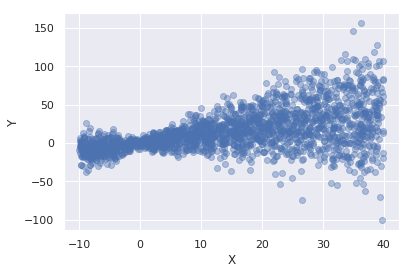

In [0]:
#@title Plot {display-mode:'form'}
plt.scatter(X,Y, alpha=0.4)
plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig("scatter.svg")
#files.download('scatter.svg')

## Linear regression in TF

In TFP, layers can return distributions or expect them as input. To make no assumptions, layers that can return distributions also can return scalars by sampling from the distribution. The framework takes care of what is needed when.

In [0]:
#@markdown Confirm that the DistributionLambda behaves like a distribution. 
layer = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
assert isinstance(layer(2.), tfd.Normal) # It is indeed a distribution.
print(layer(2.).sample(5)) # From distributions, one can sample.
print(layer(2.).loc)
print(layer(2.).stddev())

tf.Tensor([1.8463265 2.7099998 2.2535589 1.8556565 3.213562 ], shape=(5,), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [0]:
# We define a model already using a distribution as output. Technically, this changes nothing. We still only train one weight and bias, yielding y=wx+b
model = tf.keras.Sequential([
            tf.keras.layers.Dense(1), # This layer calculates y = wx + b
            tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)), # This layer takes the output of the previous and constructs a distribution conditioned on the layer inputs
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.1),
              loss='mean_squared_error')
model.fit(X, Y, epochs=40)
model.summary()


Text(0, 0.5, 'Y')

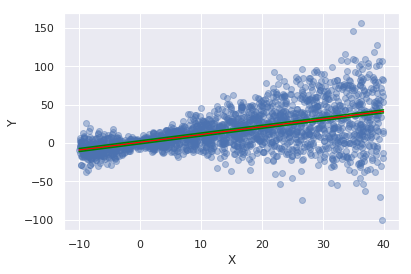

In [0]:
#@title Plot {display-mode:'form'}
#@markdown Note we plot results of a learned distribution: it's mean. We also plot the standard deviation -- but we haven't learned it, but set to 1 statically.
x = np.linspace(low,high).reshape(-1,1)
y = model(x)

plt.scatter(X,Y, alpha=0.4)
plt.plot(x, y.mean(), color = "red")
plt.plot(x, y.mean() + 2 * y.stddev(), color = "green");
plt.plot(x, y.mean() - 2 * y.stddev(), color = "green");
plt.xlabel('X')
plt.ylabel('Y')

## Global uncertainty

Model the global model uncertainty using two parameters in the dense layer to account for the two outputs: mean and standard deviation.

In [0]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(2), # This layer again calculates y = wx + b, but this time two times independently, yielding a 2-vector.
            tfp.layers.DistributionLambda(lambda t: # Interpretation of parameters t as distribution loc/scale (taking the first and second element using t[...,:1] and t[...,1:]).
                tfd.Normal(loc   = t[...,:1],
                           scale=tf.math.softplus(0.005*t[...,1:])+0.001) # Exponential uncertainty
            )
])

negloglik = lambda y, p_y: -p_y.log_prob(y) # Keras passes the output of the final layer of the model into the loss function, and for the models in this notebook, all those layers return distributions.

model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.1),
              loss=negloglik)

model.fit(X, Y, epochs=100);
model.summary()

Text(0, 0.5, 'Y')

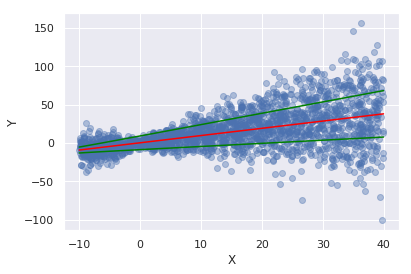

In [0]:
#@title Plot {display-mode:'form'}

x = np.linspace(low,high).reshape(-1,1)
y = model(x)

plt.scatter(X,Y, alpha=0.4)
plt.plot(x, y.mean(), color = "red");
plt.plot(x, y.mean() + 2 * y.stddev(), color = "green");
plt.plot(x, y.mean() - 2 * y.stddev(), color = "green");
plt.xlabel('X')
plt.ylabel('Y')

#plt.savefig("conf1.svg")
#files.download('conf1.svg')

## Epistemic uncertainty

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

The DenseVariational layer used now uses variational inference to fit a "surrogate" posterior to the distribution over both the `kernel` matrix and the `bias` terms which are otherwise used in a manner similar to `tf.keras.layers.Dense`.

This layer fits the "weights posterior" according to the following generative
process:

  ```none
  [K, b] ~ Prior()
  M = matmul(X, K) + b
  Y ~ Likelihood(M)
  ```

In [0]:
model = tf.keras.Sequential([
            tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable), # The DenseVariational layer consists of a posterior (two Gaussians) and a Prior (one Gaussian) with an overall of 2*(2n+n) parameters, six in our case (n=1)
            tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)
            )
])

negloglik = lambda y, p_y: -p_y.log_prob(y)

model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.1),
              loss=negloglik)

model.fit(X, Y, epochs=100);
model.summary()

In [0]:
#@title Predict
x_tst = np.linspace(low,high).reshape(-1,1)
yhats = [model(x_tst) for _ in range(100)]

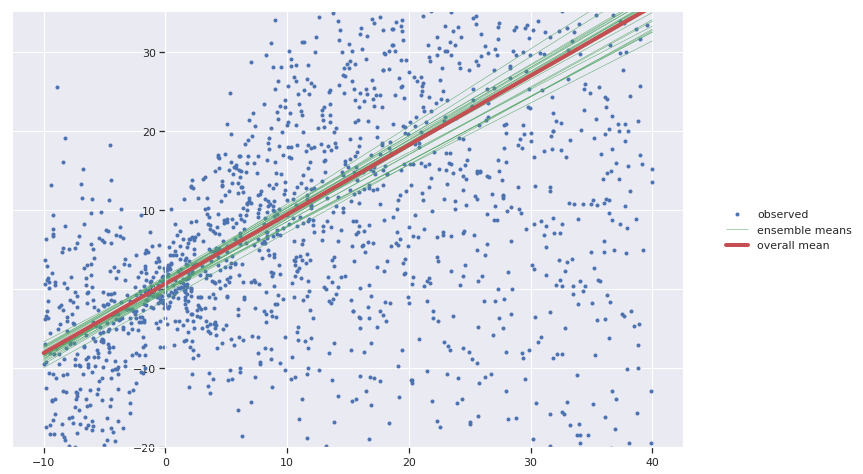

In [0]:
#@title Plot {display-mode:'form'}
plt.figure(figsize=[12, 8])  # inches
plt.clf();
plt.plot(X, Y, 'b.', label='observed');

avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'g', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-20,35);

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))


## Introducing nonlinear uncertainty

We now model the nonlinear dependency of the uncertainty by introducing more degrees of freedom in the network (additional Dense layer) with a nonlinear activation.

Here are some suggestions what to explore after that.

* Observe what happens when you change the scale of the Normal distribution to be allowed to go linearly with the x axis, versus going exponentially.
* Replace `scale=tf.math.softplus(0.005*t[...,1:])+0.001)` with `scale=tf.exp(0.005*t[...,1:])+0.001)` and run the example again.
* Change the range of the example data. Originally, it is set to the interval [-8, 15]. Change it to [-50, 50] and run the experiment again.

In [0]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(20,activation="relu"), # Layer creates a nonlinear mapping of input to output
            tf.keras.layers.Dense(2), # Layer condensing the knowledge about the input into two parameters
            tfp.layers.DistributionLambda(lambda t: # Interpretation of parameters t as distribution loc/scale (taking the first and second element using t[...,:1] and t[...,1:]).
                tfd.Normal(loc   = t[...,:1],
                           scale=tf.math.softplus(0.005*t[...,1:])+0.001)
            )
])

negloglik = lambda y, p_y: -p_y.log_prob(y)

model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.05),
              loss=negloglik)

model.fit(X, Y, epochs=100);

Text(0, 0.5, 'Y')

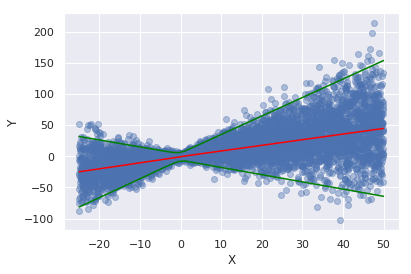

In [0]:
#@title Plot {display-mode:'form'}

x = np.linspace(low,high).reshape(-1,1)
y = model(x)

plt.scatter(X,Y, alpha=0.4)
plt.plot(x, y.mean(), color = "red");
plt.plot(x, y.mean() + 2 * y.stddev(), color = "green");
plt.plot(x, y.mean() - 2 * y.stddev(), color = "green");

plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig("conf2.svg")

#files.download('conf2.svg')

## What's next

An even better way of looking at the data is through Gaussian processes. If there is periodicity, or at least some continuity in the data, this will analyse it better. For a quick intro, see https://katbailey.github.io/post/gaussian-processes-for-dummies/

The TFP tutorial code also shows this in a practical example, using the VariationalGaussianProcess layer:
https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb#scrollTo=qmgmcmMKzOH7